# Code from data_cleaning_walkthrough and data_cleaning_walkthrough_continued

In [3]:
import pandas as pd
import numpy as np
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for file in data_files:
    read_file = pd.read_csv("{0}".format(file))
    key_name = file[:-4]
    data[key_name] = read_file
    
all_survey = pd.read_csv("survey_all.txt", delimiter='\t', encoding='windows-1252')
d75_survey = pd.read_csv("survey_d75.txt", delimiter='\t', encoding='windows-1252')
survey = pd.concat([all_survey,d75_survey], axis=0)

survey["DBN"] = survey["dbn"]
survey = survey.loc[:,["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]]
data["survey"] = survey


def pad(x):
    if len(str(x)) == 1:
        return str(x).zfill(2)
    else:
        return str(x)
    
data['hs_directory']['DBN'] = data['hs_directory']['dbn']
data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(pad)
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']


categories = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for x in categories:
    data['sat_results'][x] = pd.to_numeric(data['sat_results'][x], errors='coerce')
data['sat_results']['sat_score'] = data['sat_results'][categories[0]] + data['sat_results'][categories[1]] + data['sat_results'][categories[2]]


def lat(x):
    x = re.findall("\(.+\)", x)
    for item in x:
        item = item.replace("(", "")
        item = item.replace(")", "")
        item = item.replace(",", "")
        item = item.split()
        return item[0]

data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(lat)


def lon(x):
    x = re.findall("\(.+\)", x)
    for item in x:
        item = item.replace("(", "")
        item = item.replace(")", "")
        item = item.replace(",", "")
        item = item.split()
        return item[1]

data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(lon)
data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['lat'], errors='coerce')
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['lon'], errors='coerce')


class_size = data['class_size']
class_size = class_size[class_size['GRADE '] == '09-12']
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']
class_size = class_size.groupby('DBN')
class_size = class_size.agg(np.mean)
class_size.reset_index(inplace=True)
data['class_size'] = class_size


data['demographics'] = data['demographics'][data['demographics']['schoolyear'] == 20112012]
data['graduation'] = data['graduation'][data['graduation']['Cohort'] == "2006"]
data['graduation'] = data['graduation'][data['graduation']['Demographic'] == 'Total Cohort']


cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
for item in cols:
    data['ap_2010'][item] = pd.to_numeric(data['ap_2010'][item], errors="coerce")
    
combined = data["sat_results"]
combined = combined.merge(data['ap_2010'], on="DBN", how="left")
combined = combined.merge(data['graduation'], on="DBN", how="left")
combined = combined.merge(data['class_size'], on="DBN", how="inner")
combined = combined.merge(data['demographics'], on="DBN", how="inner")
combined = combined.merge(data['survey'], on="DBN", how="inner")
combined = combined.merge(data['hs_directory'], on="DBN", how="inner")

means = combined.mean()
combined = combined.fillna(means)
combined = combined.fillna(0)

def district(x):
    return x[0:2]

combined['school_dist'] = combined['DBN'].apply(district)
print (combined.head())

      DBN                                        SCHOOL NAME  \
0  01M292      HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448                UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                         EAST SIDE COMMUNITY SCHOOL   
3  01M509                            MARTA VALLE HIGH SCHOOL   
4  01M539  NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                     44                            390.0   
4                    159                            522.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
0                404.0                   363.0     1122.0   
1                423.0                   366.0     1172.0   
2                402.0                   370.0     1149.0   
3   

# Start of Analyzing and Visualizing data course

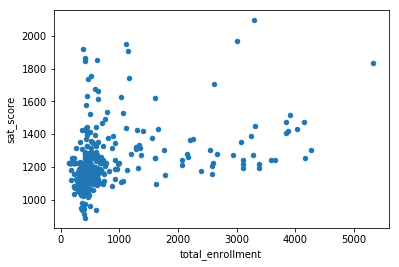

In [4]:
# Finding r values for rows correlated with 'sat_score'
# Generating scatter plot of 'total_enrollment' vs. 'sat_score'

import matplotlib.pyplot as plt

correlations = combined.corr()['sat_score']
combined.plot.scatter(x='total_enrollment', y='sat_score')
plt.show()

 

In [18]:
# Filtering through combined DataFrame to pick out rows where total_enrollment and sat_score are less than 1000
# to investigate the cluster on the bottom left of the scatter plot.

low_enrollment = combined[combined['total_enrollment'] <1000]
low_enrollment = low_enrollment[low_enrollment['sat_score'] < 1000]

print (low_enrollment['School Name'])

91       INTERNATIONAL COMMUNITY HIGH SCHOOL
125                                        0
126          BRONX INTERNATIONAL HIGH SCHOOL
139    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
179            HIGH SCHOOL OF WORLD CULTURES
188       BROOKLYN INTERNATIONAL HIGH SCHOOL
225    INTERNATIONAL HIGH SCHOOL AT PROSPECT
237               IT TAKES A VILLAGE ACADEMY
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object


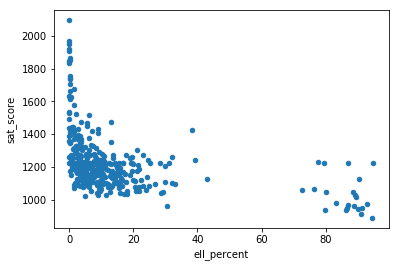

In [19]:
# Seeing that most schools have English language learners which account for low SAT scores, lets generate
# a scatter plot of ell_percent (english language learners) vs. sat_score

combined.plot.scatter(x="ell_percent", y="sat_score")
plt.show()

/Users/milesmackenzie/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/milesmackenzie/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/milesmackenzie/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


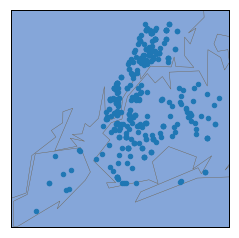

In [11]:
# Generating a map of New York city schools, drawing map boundaries, coast lines and rivers.
# Plotting by longitude and latitude that we computed earlier.

from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = combined['lon'].tolist()
latitudes = combined['lat'].tolist()

m.scatter(longitudes,latitudes, s=20, zorder=2, latlon=True)
plt.show()

/Users/milesmackenzie/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/milesmackenzie/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/milesmackenzie/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


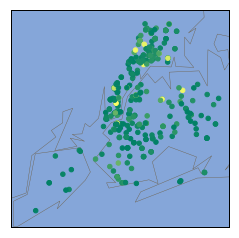

In [13]:
# Passing argument c to shade points based on ell_percent.
# Passing argument cmap to show green and yellow shades (green = low, yellow = high).
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = combined['lon'].tolist()
latitudes = combined['lat'].tolist()


m.scatter(longitudes,latitudes, s=20, zorder=2, latlon=True, c=combined['ell_percent'], cmap="summer")
plt.show()

In [14]:
# Finding mean of each column for each unique value in school_dist using groupby() and agg().

districts = combined.groupby('school_dist').agg(np.mean)
districts.reset_index(inplace=True)

print (districts.head())

  school_dist  SAT Critical Reading Avg. Score  SAT Math Avg. Score  \
0          01                       441.833333           473.333333   
1          02                       426.619092           444.186256   
2          03                       428.529851           437.997512   
3          04                       402.142857           416.285714   
4          05                       427.159915           438.236674   

   SAT Writing Avg. Score    sat_score  AP Test Takers   Total Exams Taken  \
0              439.333333  1354.500000       116.681090         173.019231   
1              424.832836  1295.638184       128.908454         201.516827   
2              426.915672  1293.443035       156.183494         244.522436   
3              405.714286  1224.142857       129.016484         183.879121   
4              419.666098  1285.062687        85.722527         115.725275   

   Number of Exams with scores 3 4 or 5  Total Cohort  CSD    ...      \
0                            13

/Users/milesmackenzie/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/milesmackenzie/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/milesmackenzie/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


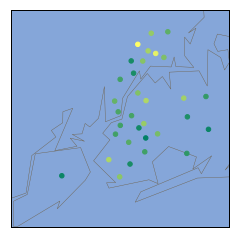

In [17]:
# Now that we have taken the means of all districts, we'll plot 
# the means of lon, lat and ell_percent.
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m.scatter(longitudes,latitudes, s=20, zorder=2, latlon=True, c=districts['ell_percent'], cmap="summer")
plt.show()